# Mertion Portfolio
$$-\frac{\partial V}{\partial \tau} - \frac{\left(\mu - r\right)^{2}}{2 \sigma^{2}}\frac{\left( \frac{\partial V}{\partial x} \right)^{2}}{\frac{\partial^{2} V}{\partial x^{2}}} + \frac{\partial V}{\partial x}r x + \frac{\gamma}{1-\gamma}\left(\frac{\partial V}{\partial x}\right)^\frac{\gamma-1}{\gamma} = \rho V$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns

from tqdm import tqdm

# GPU and Seed Setting

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(1)

cuda:2


# Given Parameters or Constants

In [3]:
mu = 0.07 # drift / expected return on stock
r = 0.01 # risk free rate
sigma = 0.2 # volatility
T = 1 # maturity
gamma = 0.3 # relative risk-aversion
rho = 0.02 # utility  discount rate
eps = 0.1 # no bequest(small constant )
L = 2.0; # maximum wealth

n_t = 365 #number of time step
n_x = 100 #Number of spatial grid

# Mesh Generating

## Exact Solution and Terminal Condition

### Define Exact Solution and Exact Grid
$$f\left(T-\tau\right)^{\gamma} \frac{x^{1-\gamma}}{1-\gamma}$$
=  


In [4]:
def exact_sol(t, x, mu, gamma, eps, sigma, r):
    '''
    Return optimal value function i.e. V^*(t, W_t)

    Parameters
    --------------
    t : time mesh
    x : spatial mesh
    mu : mu
    gamma : gamma
    eps : epsilon
    sigma : sigma
    r : r

    Return
    ----------
    f(t) * x^{1-\gamma}/1-\gamma
    '''
    nu = rho - (1. - gamma) * ((mu - r)**2 / (2. * sigma**2 * gamma) + r)  # sth factor of f' = nu f - 1
    nu =(-1)* nu / gamma
    # V = (1. + (nu * eps - 1.) * torch.exp(-nu * (T - t)))**gamma
    # V = (1. + (nu * eps - 1.) * torch.exp(-nu * (T - t))) / nu
    V = (-1. + (nu * eps + 1.) * torch.exp(nu * t)) / nu
    V = V ** gamma
    # print(V)
    V *= x**(1. - gamma) / (1. - gamma)
    return V

### Initial Condition and Its grid
$$\epsilon^{\gamma} \frac{x^{1-\gamma}}{1-\gamma}$$

In [5]:
def initial_cond(x, gamma, eps):
    '''Terminal_condition

    Parameters
    -------------
    x : spatial mesh
    gamma : gamma
    eps : epsilon

    Return
    -----------
    Terminal condition  \epsilon^{\gamma} \frac{x^{1-\gamma}}{1-\gamma}
    '''

    return eps**gamma * x**(1-gamma)/(1-gamma)

## Mesh generating

In [6]:
def mesh_generating(L, T, n_x, n_t, eps, gamma, sigma, r):
    '''Make a mesh.
    Parameters
    ------------------
    L : Maximum Wealth
    T : Maturity
    n_x : spatial number
    n_t : time number
    eps : epsilon
    gamma : gamma
    sigma : sigma,
    r
    
    Returns
    -------------
    tx, tx_grid, x_init, x_bdry, v_init, v_bdry
    '''
    
    ep = 1e-5 # For non zero x
    t = torch.linspace(0, T, n_t)  # Input data for t (n_t x 1) (0, T)
    # x = torch.linspace(ep, L, n_x) # Input data for t (n_x x 1) (ep, L)
    x = torch.linspace(0, L, n_x) # Input data for t (n_x x 1) (ep, L)
    tx = torch.meshgrid(t, x, indexing='ij') # Get a meshgrid
    
    tx_grid = torch.cat([tx[0].reshape(-1, 1), tx[1].reshape(-1,1)], dim=1) # get grid in two columbs in order to t and x
    true_grid = torch.meshgrid(t[1:], x[1:-1])
    true_grid = torch.cat([true_grid[0].reshape(-1, 1), true_grid[1].reshape(-1,1)], dim=1) # get grid in two columbs in order to t and x

    x_init = tx_grid[tx_grid[:, 0]==0] # space domain of the terminal time
    x_bdry = tx_grid[torch.logical_or((tx_grid[:, 1]==0), (tx_grid[:, 1]==L))] # Boundary of the domain
    # print(x_bdry[:, 1])
    v_init = initial_cond(x_init[:,1], gamma, eps).view(-1, 1)
    # v_bdry = torch.zeros_like(x_bdry[:, 0].view(-1,1))
    # print(v_bdry)
    ex_sol = exact_sol(x_bdry[:, 0], x_bdry[:, 1], mu, gamma, eps, sigma, r).view(-1, 1)
    v_bdry = ex_sol
    # print(ex_sol)

    return tx, tx_grid, x_init, x_bdry, v_init, v_bdry, true_grid



In [7]:
tot_grid, tx_grid, x_init, x_bdry, v_init, v_bdry, true_grid = mesh_generating(L, T, n_x, n_t, eps, gamma, sigma, r)

/opt/ohpc/pub/python/3.11.2/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


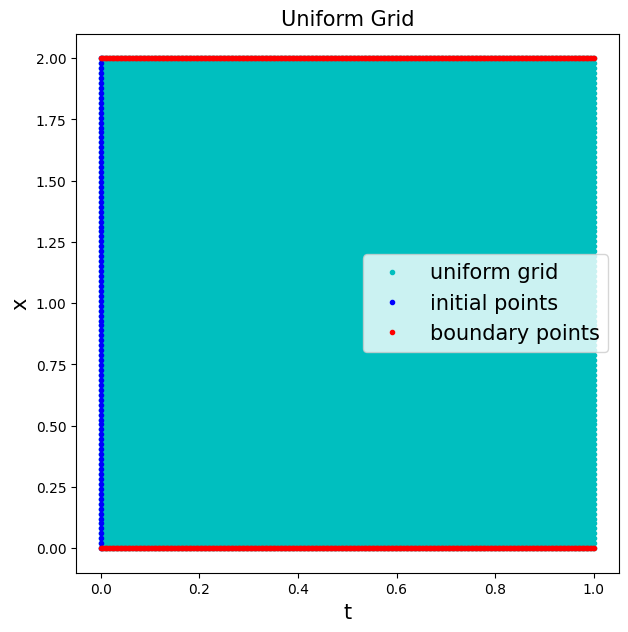

In [9]:
plt.figure(figsize=(7,7))
plt.plot(tx_grid[:,0], tx_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(x_init[:,0], x_init[:,1], 'bo', markersize=3, label='initial points')
plt.plot(x_bdry[:,0], x_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='center right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('t', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.savefig('burgers_data', dpi=100)

# Autograd and Plug in

## Autograd

In [9]:
def derivative(y, t):
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

## PDE

In [10]:
def given_PDE(v, v_t, v_x, v_xx, mu, r, sigma, x, gamma, rho, t=None):
    '''PDE

    Parameters
    --------------
    v_t :
    v_x :
    v_xx :
    mu :
    r :
    sigma :
    x :
    gamma :
    rho :
    t=None Actually do not need

    Returns
    ----------------
    PDE
    '''

    return -v_t - (mu - r)**2 / (2. * sigma**2) * v_x**2 / v_xx \
    + v_x * r * x + gamma / (1. - gamma) * v_x*((gamma - 1.)/gamma) - rho * v

# PINN

In [11]:
class MPINN(nn.Module):
    """Merton Portfolio Model using PINN

    Initializing Parameters
    -----------
    n_x : spatial number

    Attributes
    ---------------
    forward
    """
    def __init__(self, hidden_dims):
        '''initializing'''
        super(MPINN, self).__init__()
        self.layers = []
        for i in range(len(hidden_dims)-1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.layers = nn.ModuleList(self.layers)

        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)

        # self.act = nn.Tanh()
        # self.act = nn.PReLU()
        # self.act = nn.ReLU()
        self.act = nn.Sigmoid()

    def forward(self, x):
        # x = nn.functional.softplus(x) # log(1+exp(x)) 0 제거
        # return torch.exp(self.net(t)) # V^* = eps^gamma * e^g(t) * (log(1+e^x))^{1-gamma} / (1-gamma)
        # return torch.exp(self.net)

        for layer in self.layers[:-1]:
            x = self.act(layer(x))

        x = self.layers[-1](x)

        return x



## Instance of the PINN

In [12]:
model = MPINN(hidden_dims=[2, 200, 200, 200, 200, 1])

# Pass to GPU

In [13]:
model = model.to(device)

# tx_grid = tx_grid.to(device).requires_grad_(True)
true_grid = true_grid.to(device).requires_grad_(True)

x_init = x_init.to(device)                             # Pass data to GPU
v_init = v_init.to(device)                             # Pass data to GPU
x_bdry = x_bdry.to(device)                             # Pass data to GPU
v_bdry = v_bdry.to(device)                             # Pass data to GPU

def get_loss_tc(model, t_tc, x_tc):
    u_sol_tc = get_sol_tc(t_tc, x_tc)
    u_pred_tc = model(t_tc, x_tc)
    loss = F.mse_loss(u_sol_tc, u_pred_tc)
    return loss

t_tc, x_tc = gen_t_x_tc()   
t_tc = x_tc.cuda()
x_tc = t_tc.cuda()
get_loss_tc(model, t_tc, x_tc)

# Optimizer and Loss function

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) ## Using optimizer Adam with learning rate 1e-3

loss_fn = nn.MSELoss() # According to the paper it will be not enough
# loss_fn = nn.nanmean() #### 허정규 교수님 loss


# Model Training

In [15]:
model.train() # To Train

epochs = 10000

In [16]:
loss_list = []
for i in tqdm(range(1, epochs+1)):
    optimizer.zero_grad()

    # Prediction
    output = model(true_grid) # Grid prediction
    output_init = model(x_init) # Term prediction
    output_bdry = model(x_bdry) # Boundary prediction
    output_cal = output.view(-1, 1)

    # print(output)


    grad_output = derivative(output, true_grid)
    # print(grad_output, "u")
    # grad_output = derivative(output, dom_grid[:, 1])
    # time_output = derivative(output, dom_grid[:, 0])
    # print(grad_output)
    output_t = grad_output[:, 0].view(-1, 1)
    output_x = grad_output[:, 1].view(-1, 1)
    # output_xx = derivative(grad_output[:, 1], true_grid)[:, 1].view(-1, 1)
    output_xx = derivative(grad_output[:, 1], true_grid)[:, 1].view(-1, 1)
    # print(output_t,'\n', output_x, '\n', output_xx) if i is 1 else None
    # print(output_cal, output_cal+ true_grid[:, 1].view(-1,1))
    # print(output_cal.size(), output_init.size(), output_bdry.size()) if i == 1 else None
    # print(grad_output.size(), output_t.size(), output_x.size(), output_xx.size()) if i == 1 else None
    # print(v_term.size(), v_bdry.size(), x_bdry.size()) if i == 1 else None

    # Loss
    loss_init = loss_fn(output_init, v_init)
    loss_bdry = loss_fn(output_bdry, v_bdry)
    PDE = given_PDE(output_cal, output_t, output_x, output_xx, mu, r, sigma, true_grid[:, 1].view(-1,1), gamma, rho)
    # print(PDE)
    loss_ge = loss_fn(PDE, torch.zeros_like(PDE))
    # print(loss_init)
    # print(loss_bdry)
    # print(loss_ge)
    loss = loss_ge + loss_init + loss_bdry
    loss.backward()

    optimizer.step()

    loss_list.append(loss.item())

    if not i % 500:
        print(f"Epoch {i:10d}, Loss: loss init {loss_init:10.5e},  loss bdry {loss_bdry:10.5e}, loss_ge {loss_ge:10.5e}")

print("Training Finished.")

  1%|          | 105/10000 [00:03<04:26, 37.19it/s]

Epoch        100, Loss: loss init 7.10060e-02,  loss bdry 2.96676e-01, loss_ge 2.58747e-01


  2%|▏         | 205/10000 [00:06<04:22, 37.26it/s]

Epoch        200, Loss: loss init 8.44845e-02,  loss bdry 2.33030e-01, loss_ge 4.79703e-02


  3%|▎         | 305/10000 [00:08<04:25, 36.56it/s]

Epoch        300, Loss: loss init 6.99626e-02,  loss bdry 2.19127e-01, loss_ge 5.08907e-02


  4%|▍         | 405/10000 [00:11<04:19, 36.96it/s]

Epoch        400, Loss: loss init 6.20959e-02,  loss bdry 1.08574e-01, loss_ge 1.00608e-02


  5%|▌         | 505/10000 [00:14<04:12, 37.59it/s]

Epoch        500, Loss: loss init 3.60700e-02,  loss bdry 6.95353e-02, loss_ge 8.99598e-03


  6%|▌         | 605/10000 [00:16<04:09, 37.64it/s]

Epoch        600, Loss: loss init 4.10352e-02,  loss bdry 5.23546e-02, loss_ge 5.16871e-03


  7%|▋         | 705/10000 [00:19<04:07, 37.63it/s]

Epoch        700, Loss: loss init 3.90963e-02,  loss bdry 4.79769e-02, loss_ge 1.94134e-03


  8%|▊         | 805/10000 [00:22<04:08, 36.99it/s]

Epoch        800, Loss: loss init 3.92795e-02,  loss bdry 4.58289e-02, loss_ge 9.32596e-04


  9%|▉         | 905/10000 [00:25<04:07, 36.81it/s]

Epoch        900, Loss: loss init 3.95428e-02,  loss bdry 4.52904e-02, loss_ge 8.64398e-03


 10%|█         | 1005/10000 [00:27<04:00, 37.46it/s]

Epoch       1000, Loss: loss init 3.84690e-02,  loss bdry 4.37831e-02, loss_ge 5.14734e-03


 11%|█         | 1105/10000 [00:30<03:58, 37.30it/s]

Epoch       1100, Loss: loss init 3.78012e-02,  loss bdry 4.19875e-02, loss_ge 3.01520e-03


 12%|█▏        | 1205/10000 [00:33<03:55, 37.37it/s]

Epoch       1200, Loss: loss init 3.66236e-02,  loss bdry 4.08629e-02, loss_ge 3.66840e-03


 13%|█▎        | 1305/10000 [00:35<03:52, 37.35it/s]

Epoch       1300, Loss: loss init 3.58311e-02,  loss bdry 3.88247e-02, loss_ge 2.36446e-03


 14%|█▍        | 1405/10000 [00:38<03:51, 37.08it/s]

Epoch       1400, Loss: loss init 3.44197e-02,  loss bdry 3.70587e-02, loss_ge 2.06900e-03


 15%|█▌        | 1505/10000 [00:41<03:54, 36.22it/s]

Epoch       1500, Loss: loss init 3.31172e-02,  loss bdry 3.49264e-02, loss_ge 1.95066e-03


 16%|█▌        | 1605/10000 [00:43<03:46, 37.01it/s]

Epoch       1600, Loss: loss init 3.17679e-02,  loss bdry 3.27557e-02, loss_ge 5.57439e-03


 17%|█▋        | 1705/10000 [00:46<03:42, 37.24it/s]

Epoch       1700, Loss: loss init 3.01124e-02,  loss bdry 2.92248e-02, loss_ge 4.70933e-03


 18%|█▊        | 1805/10000 [00:49<03:42, 36.91it/s]

Epoch       1800, Loss: loss init 2.81566e-02,  loss bdry 2.51033e-02, loss_ge 1.76533e-03


 19%|█▉        | 1905/10000 [00:52<03:38, 37.02it/s]

Epoch       1900, Loss: loss init 2.56957e-02,  loss bdry 2.20559e-02, loss_ge 2.13371e-03


 20%|██        | 2005/10000 [00:54<03:33, 37.37it/s]

Epoch       2000, Loss: loss init 2.28257e-02,  loss bdry 1.84840e-02, loss_ge 2.87164e-03


 21%|██        | 2105/10000 [00:57<03:34, 36.82it/s]

Epoch       2100, Loss: loss init 2.04430e-02,  loss bdry 1.50974e-02, loss_ge 1.65057e-03


 22%|██▏       | 2205/10000 [01:00<03:35, 36.12it/s]

Epoch       2200, Loss: loss init 2.10951e-02,  loss bdry 1.17098e-02, loss_ge 5.21720e-02


 23%|██▎       | 2305/10000 [01:02<03:26, 37.32it/s]

Epoch       2300, Loss: loss init 2.06511e-02,  loss bdry 1.74712e-02, loss_ge 1.19672e-03


 24%|██▍       | 2405/10000 [01:05<03:25, 36.88it/s]

Epoch       2400, Loss: loss init 1.83651e-02,  loss bdry 1.09932e-02, loss_ge 8.42736e-04


 25%|██▌       | 2505/10000 [01:08<03:20, 37.42it/s]

Epoch       2500, Loss: loss init 1.52555e-02,  loss bdry 8.31295e-03, loss_ge 1.60690e-03


 26%|██▌       | 2605/10000 [01:10<03:18, 37.27it/s]

Epoch       2600, Loss: loss init 6.91360e-02,  loss bdry 1.94772e-01, loss_ge 5.26561e-02


 27%|██▋       | 2705/10000 [01:13<03:17, 36.88it/s]

Epoch       2700, Loss: loss init 1.85089e-02,  loss bdry 1.85664e-02, loss_ge 3.45355e-03


 28%|██▊       | 2805/10000 [01:16<03:18, 36.33it/s]

Epoch       2800, Loss: loss init 1.89440e-02,  loss bdry 1.36282e-02, loss_ge 2.01152e-03


 29%|██▉       | 2905/10000 [01:19<03:11, 37.14it/s]

Epoch       2900, Loss: loss init 1.67193e-02,  loss bdry 1.16179e-02, loss_ge 4.25649e-03


 30%|███       | 3005/10000 [01:21<03:06, 37.46it/s]

Epoch       3000, Loss: loss init 1.75143e-02,  loss bdry 9.49487e-03, loss_ge 1.21955e-02


 31%|███       | 3105/10000 [01:24<03:11, 36.03it/s]

Epoch       3100, Loss: loss init 1.54851e-02,  loss bdry 7.74859e-03, loss_ge 1.33992e-02


 32%|███▏      | 3205/10000 [01:27<03:07, 36.15it/s]

Epoch       3200, Loss: loss init 1.26098e-02,  loss bdry 6.30555e-03, loss_ge 1.21929e-03


 33%|███▎      | 3305/10000 [01:30<03:03, 36.53it/s]

Epoch       3300, Loss: loss init 1.07230e-02,  loss bdry 5.08520e-03, loss_ge 8.28607e-04


 34%|███▍      | 3405/10000 [01:32<02:59, 36.77it/s]

Epoch       3400, Loss: loss init 9.94424e-03,  loss bdry 5.76333e-03, loss_ge 1.14760e-02


 35%|███▌      | 3505/10000 [01:35<02:55, 37.02it/s]

Epoch       3500, Loss: loss init 8.65949e-03,  loss bdry 3.83703e-03, loss_ge 1.91948e-03


 36%|███▌      | 3605/10000 [01:38<02:54, 36.72it/s]

Epoch       3600, Loss: loss init 7.63163e-03,  loss bdry 4.34949e-03, loss_ge 4.79871e-03


 37%|███▋      | 3705/10000 [01:41<02:51, 36.63it/s]

Epoch       3700, Loss: loss init 7.17038e-03,  loss bdry 4.52155e-03, loss_ge 1.51669e-03


 38%|███▊      | 3805/10000 [01:43<02:45, 37.39it/s]

Epoch       3800, Loss: loss init 6.48506e-03,  loss bdry 3.46519e-03, loss_ge 1.16973e-03


 39%|███▉      | 3905/10000 [01:46<02:47, 36.43it/s]

Epoch       3900, Loss: loss init 6.27022e-03,  loss bdry 3.45170e-03, loss_ge 6.11202e-03


 40%|████      | 4005/10000 [01:49<02:44, 36.43it/s]

Epoch       4000, Loss: loss init 5.74915e-03,  loss bdry 3.37507e-03, loss_ge 6.37915e-04


 41%|████      | 4105/10000 [01:51<02:38, 37.25it/s]

Epoch       4100, Loss: loss init 5.92458e-03,  loss bdry 3.60865e-03, loss_ge 9.12750e-03


 42%|████▏     | 4205/10000 [01:54<02:37, 36.74it/s]

Epoch       4200, Loss: loss init 5.27978e-03,  loss bdry 3.13507e-03, loss_ge 4.45692e-03


 43%|████▎     | 4305/10000 [01:57<02:35, 36.55it/s]

Epoch       4300, Loss: loss init 5.55150e-03,  loss bdry 3.56607e-03, loss_ge 3.19310e-03


 44%|████▍     | 4405/10000 [02:00<02:35, 35.90it/s]

Epoch       4400, Loss: loss init 5.29045e-03,  loss bdry 3.54028e-03, loss_ge 2.32600e-03


 45%|████▌     | 4505/10000 [02:02<02:31, 36.23it/s]

Epoch       4500, Loss: loss init 4.97729e-03,  loss bdry 3.29034e-03, loss_ge 3.51432e-03


 46%|████▌     | 4605/10000 [02:05<02:25, 37.13it/s]

Epoch       4600, Loss: loss init 4.93207e-03,  loss bdry 3.31359e-03, loss_ge 3.26970e-03


 47%|████▋     | 4705/10000 [02:08<02:23, 36.86it/s]

Epoch       4700, Loss: loss init 4.70456e-03,  loss bdry 3.25157e-03, loss_ge 5.96786e-03


 48%|████▊     | 4805/10000 [02:11<02:25, 35.79it/s]

Epoch       4800, Loss: loss init 4.69732e-03,  loss bdry 3.36034e-03, loss_ge 5.68608e-03


 49%|████▉     | 4905/10000 [02:13<02:18, 36.83it/s]

Epoch       4900, Loss: loss init 4.54791e-03,  loss bdry 3.36187e-03, loss_ge 7.41262e-03


 50%|█████     | 5005/10000 [02:16<02:16, 36.69it/s]

Epoch       5000, Loss: loss init 4.27734e-03,  loss bdry 3.48528e-03, loss_ge 1.31048e-03


 51%|█████     | 5105/10000 [02:19<02:11, 37.32it/s]

Epoch       5100, Loss: loss init 4.29704e-03,  loss bdry 3.07318e-03, loss_ge 9.00669e-04


 52%|█████▏    | 5205/10000 [02:21<02:08, 37.22it/s]

Epoch       5200, Loss: loss init 4.08174e-03,  loss bdry 2.84558e-03, loss_ge 3.73847e-03


 53%|█████▎    | 5305/10000 [02:24<02:08, 36.61it/s]

Epoch       5300, Loss: loss init 4.17717e-03,  loss bdry 3.20070e-03, loss_ge 5.47809e-03


 54%|█████▍    | 5405/10000 [02:27<02:07, 35.90it/s]

Epoch       5400, Loss: loss init 4.69379e-03,  loss bdry 3.61207e-03, loss_ge 1.42342e-03


 55%|█████▌    | 5505/10000 [02:30<02:03, 36.40it/s]

Epoch       5500, Loss: loss init 3.96064e-03,  loss bdry 2.76336e-03, loss_ge 2.45947e-03


 56%|█████▌    | 5605/10000 [02:32<02:01, 36.30it/s]

Epoch       5600, Loss: loss init 4.13737e-03,  loss bdry 3.42927e-03, loss_ge 4.38696e-03


 57%|█████▋    | 5705/10000 [02:35<01:56, 36.99it/s]

Epoch       5700, Loss: loss init 3.80495e-03,  loss bdry 2.72404e-03, loss_ge 1.83187e-03


 58%|█████▊    | 5805/10000 [02:38<01:57, 35.78it/s]

Epoch       5800, Loss: loss init 4.51167e-03,  loss bdry 3.52520e-03, loss_ge 2.05439e-03


 59%|█████▉    | 5905/10000 [02:41<01:54, 35.92it/s]

Epoch       5900, Loss: loss init 3.73373e-03,  loss bdry 2.75624e-03, loss_ge 7.27879e-03


 60%|██████    | 6005/10000 [02:43<01:49, 36.39it/s]

Epoch       6000, Loss: loss init 3.72805e-03,  loss bdry 2.54558e-03, loss_ge 2.70762e-03


 61%|██████    | 6105/10000 [02:46<01:44, 37.30it/s]

Epoch       6100, Loss: loss init 4.02281e-03,  loss bdry 2.95844e-03, loss_ge 7.72064e-04


 62%|██████▏   | 6205/10000 [02:49<01:42, 37.12it/s]

Epoch       6200, Loss: loss init 4.05866e-03,  loss bdry 3.19688e-03, loss_ge 7.51301e-04


 63%|██████▎   | 6305/10000 [02:51<01:38, 37.50it/s]

Epoch       6300, Loss: loss init 3.61576e-03,  loss bdry 2.29500e-03, loss_ge 4.91968e-04


 64%|██████▍   | 6405/10000 [02:54<01:39, 36.16it/s]

Epoch       6400, Loss: loss init 3.41694e-03,  loss bdry 2.40034e-03, loss_ge 3.87711e-03


 65%|██████▌   | 6505/10000 [02:57<01:33, 37.36it/s]

Epoch       6500, Loss: loss init 3.46160e-03,  loss bdry 2.46323e-03, loss_ge 8.30756e-03


 66%|██████▌   | 6605/10000 [02:59<01:31, 37.23it/s]

Epoch       6600, Loss: loss init 3.65288e-03,  loss bdry 2.63262e-03, loss_ge 4.18574e-03


 67%|██████▋   | 6705/10000 [03:02<01:28, 37.22it/s]

Epoch       6700, Loss: loss init 6.52087e-03,  loss bdry 5.73814e-03, loss_ge 1.06341e-03


 68%|██████▊   | 6805/10000 [03:05<01:25, 37.46it/s]

Epoch       6800, Loss: loss init 3.34035e-03,  loss bdry 2.15218e-03, loss_ge 4.85649e-04


 69%|██████▉   | 6905/10000 [03:08<01:23, 36.89it/s]

Epoch       6900, Loss: loss init 3.67337e-03,  loss bdry 3.25728e-03, loss_ge 2.50882e-03


 70%|███████   | 7005/10000 [03:10<01:19, 37.44it/s]

Epoch       7000, Loss: loss init 3.32836e-03,  loss bdry 2.37718e-03, loss_ge 5.12813e-04


 71%|███████   | 7105/10000 [03:13<01:17, 37.30it/s]

Epoch       7100, Loss: loss init 4.33093e-03,  loss bdry 3.73343e-03, loss_ge 1.44572e-03


 72%|███████▏  | 7205/10000 [03:16<01:15, 37.17it/s]

Epoch       7200, Loss: loss init 3.76187e-03,  loss bdry 2.79893e-03, loss_ge 2.83293e-03


 73%|███████▎  | 7305/10000 [03:18<01:12, 37.34it/s]

Epoch       7300, Loss: loss init 3.15975e-03,  loss bdry 2.23309e-03, loss_ge 2.59635e-03


 74%|███████▍  | 7405/10000 [03:21<01:09, 37.43it/s]

Epoch       7400, Loss: loss init 3.08658e-03,  loss bdry 2.13845e-03, loss_ge 1.31690e-03


 75%|███████▌  | 7505/10000 [03:24<01:09, 35.75it/s]

Epoch       7500, Loss: loss init 4.38890e-03,  loss bdry 3.41357e-03, loss_ge 1.56750e-03


 76%|███████▌  | 7605/10000 [03:27<01:05, 36.78it/s]

Epoch       7600, Loss: loss init 3.10404e-03,  loss bdry 1.95871e-03, loss_ge 2.59540e-03


 77%|███████▋  | 7705/10000 [03:29<01:01, 37.49it/s]

Epoch       7700, Loss: loss init 4.50661e-03,  loss bdry 3.90240e-03, loss_ge 1.78732e-03


 78%|███████▊  | 7805/10000 [03:32<00:58, 37.37it/s]

Epoch       7800, Loss: loss init 3.94880e-03,  loss bdry 3.14926e-03, loss_ge 6.25151e-04


 79%|███████▉  | 7905/10000 [03:35<00:56, 37.03it/s]

Epoch       7900, Loss: loss init 2.99800e-03,  loss bdry 1.73057e-03, loss_ge 3.15056e-03


 80%|████████  | 8005/10000 [03:37<00:55, 35.95it/s]

Epoch       8000, Loss: loss init 3.04756e-03,  loss bdry 1.71927e-03, loss_ge 5.71113e-03


 81%|████████  | 8105/10000 [03:40<00:50, 37.19it/s]

Epoch       8100, Loss: loss init 2.87658e-03,  loss bdry 1.69229e-03, loss_ge 6.10497e-03


 82%|████████▏ | 8205/10000 [03:43<00:47, 37.47it/s]

Epoch       8200, Loss: loss init 2.96530e-03,  loss bdry 1.81186e-03, loss_ge 1.46225e-03


 83%|████████▎ | 8305/10000 [03:45<00:45, 37.42it/s]

Epoch       8300, Loss: loss init 2.93034e-03,  loss bdry 2.01690e-03, loss_ge 1.46417e-03


 84%|████████▍ | 8405/10000 [03:48<00:43, 36.80it/s]

Epoch       8400, Loss: loss init 2.78878e-03,  loss bdry 1.62960e-03, loss_ge 2.99298e-03


 85%|████████▌ | 8505/10000 [03:51<00:40, 36.97it/s]

Epoch       8500, Loss: loss init 3.42910e-03,  loss bdry 1.96789e-03, loss_ge 3.97594e-03


 86%|████████▌ | 8605/10000 [03:53<00:38, 36.09it/s]

Epoch       8600, Loss: loss init 2.87903e-03,  loss bdry 1.83791e-03, loss_ge 9.27668e-04


 87%|████████▋ | 8705/10000 [03:56<00:35, 36.71it/s]

Epoch       8700, Loss: loss init 3.22899e-03,  loss bdry 2.02048e-03, loss_ge 1.00958e-03


 88%|████████▊ | 8805/10000 [03:59<00:32, 36.71it/s]

Epoch       8800, Loss: loss init 2.70010e-03,  loss bdry 1.62534e-03, loss_ge 2.50858e-03


 89%|████████▉ | 8905/10000 [04:02<00:29, 36.93it/s]

Epoch       8900, Loss: loss init 2.68102e-03,  loss bdry 1.46563e-03, loss_ge 4.80216e-04


 90%|█████████ | 9005/10000 [04:04<00:26, 37.32it/s]

Epoch       9000, Loss: loss init 3.20551e-03,  loss bdry 1.55036e-03, loss_ge 7.44345e-03


 91%|█████████ | 9105/10000 [04:07<00:23, 37.38it/s]

Epoch       9100, Loss: loss init 3.41238e-03,  loss bdry 2.28420e-03, loss_ge 1.71158e-03


 92%|█████████▏| 9205/10000 [04:10<00:21, 37.00it/s]

Epoch       9200, Loss: loss init 2.60874e-03,  loss bdry 1.38012e-03, loss_ge 1.08203e-03


 93%|█████████▎| 9305/10000 [04:12<00:18, 37.22it/s]

Epoch       9300, Loss: loss init 2.99266e-03,  loss bdry 1.73939e-03, loss_ge 8.44634e-04


 94%|█████████▍| 9405/10000 [04:15<00:15, 37.45it/s]

Epoch       9400, Loss: loss init 2.58309e-03,  loss bdry 1.55201e-03, loss_ge 2.43328e-03


 95%|█████████▌| 9505/10000 [04:18<00:13, 37.37it/s]

Epoch       9500, Loss: loss init 2.58980e-03,  loss bdry 1.28431e-03, loss_ge 1.65770e-03


 96%|█████████▌| 9605/10000 [04:20<00:10, 37.24it/s]

Epoch       9600, Loss: loss init 2.98126e-03,  loss bdry 2.55439e-03, loss_ge 1.25978e-03


 97%|█████████▋| 9705/10000 [04:23<00:08, 36.38it/s]

Epoch       9700, Loss: loss init 2.49802e-03,  loss bdry 1.28244e-03, loss_ge 1.15845e-03


 98%|█████████▊| 9805/10000 [04:26<00:05, 37.28it/s]

Epoch       9800, Loss: loss init 2.80120e-03,  loss bdry 1.07931e-03, loss_ge 1.53226e-03


 99%|█████████▉| 9905/10000 [04:29<00:02, 37.47it/s]

Epoch       9900, Loss: loss init 3.82115e-03,  loss bdry 2.91833e-03, loss_ge 4.02267e-03


100%|██████████| 10000/10000 [04:31<00:00, 36.82it/s]

Epoch      10000, Loss: loss init 2.40977e-03,  loss bdry 1.57091e-03, loss_ge 1.38800e-03
Training Finished.


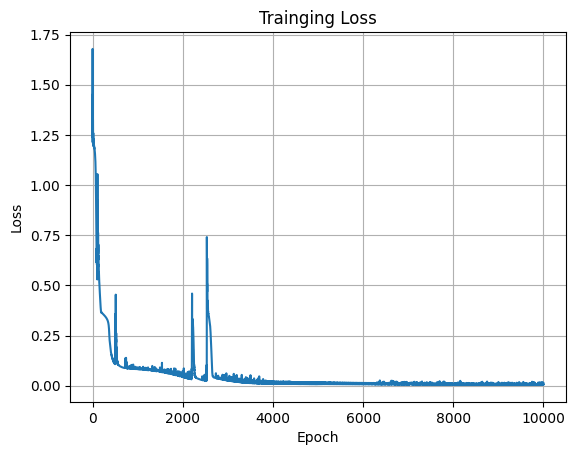

0.005368671379983425


In [17]:
plt.plot(np.linspace(0, epochs, epochs), np.array(loss_list))
plt.title("Trainging Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("Training Loss")
plt.show()
print(loss_list[-1])

## To CPU

In [18]:
true_grid = true_grid.cpu().detach().numpy()
output = output.cpu().detach().numpy() # Grid prediction
output_init =  output_init.cpu().detach().numpy()# Term prediction
output_bdry = output_bdry.cpu().detach().numpy() # Boundary prediction
# output_cal = output.view(-1, 1)


In [20]:
output1 = output.reshape(n_t-1, n_x-2)

In [21]:
full_mesh = np.zeros_like(tot_grid[0])
full_mesh[0, :].shape
full_mesh[0, :] = output_init[:,0]
full_mesh[1:, 1:-1] = output1
full_mesh[1:, 0] = output_bdry.reshape(n_t, 2)[1:,0]
full_mesh[1:, -1] = output_bdry.reshape(n_t, 2)[1:, -1]

In [24]:
np.save('pinn.npy', full_mesh)

In [22]:
exact = exact_sol(tot_grid[0], tot_grid[1], mu, gamma, eps, sigma, r)

In [23]:
np.save("exact_mesh", exact)

[[0.         0.04663141 0.07575294 ... 1.1466179  1.1548797  1.1631163 ]
 [0.         0.04702381 0.0763904  ... 1.1562666  1.1645979  1.1729038 ]
 [0.         0.04740908 0.07701629 ... 1.1657401  1.1741397  1.1825137 ]
 ...
 [0.         0.10062587 0.1634672  ... 2.4742854  2.4921136  2.5098875 ]
 [0.         0.10071512 0.16361219 ... 2.47648    2.4943242  2.5121136 ]
 [0.         0.10080424 0.16375697 ... 2.4786716  2.4965312  2.5143366 ]]


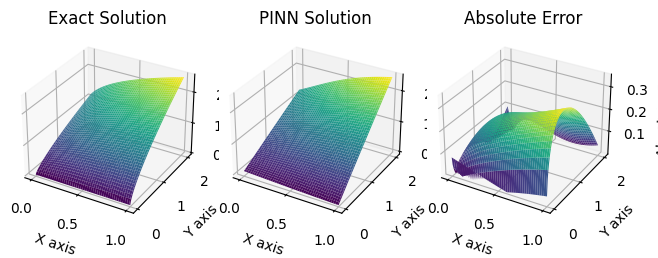

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for x and y
x = tot_grid[0]
# print(x)
y = tot_grid[1]
# x, y = np.meshgrid(x, y)

# Define the function f(x, y)
def f(x, y):
    return exact_sol(x, y, mu, gamma, eps, sigma, r)

# Compute the function values
z = f(x, y)
print(z.numpy())

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

ax1 = fig.add_subplot(132, projection='3d')
ax1.plot_surface(x, y, full_mesh, cmap='viridis')

ax2 = fig.add_subplot(133, projection='3d')
ax2.plot_surface(x, y, np.abs(full_mesh-z.numpy()), cmap='viridis')

# Add labels
ax.set_title('Exact Solution')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis Exact Solution')

ax1.set_title('PINN Solution')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Z axis PINN Solution')

ax2.set_title('Absolute Error')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Absolute Error')
# Show plot
plt.tight_layout()
fig.savefig('3d_plots.png')
plt.show()


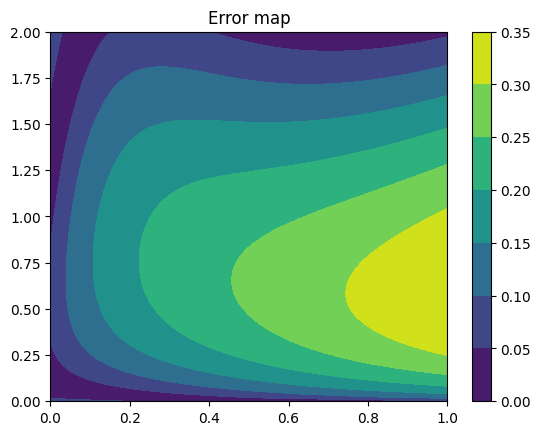

In [26]:
plt.figure()
cp = plt.contourf(x, y, np.abs(full_mesh-z.numpy()), cmap='viridis')
plt.colorbar(cp)
plt.savefig('contour_plot.png')
plt.title("Error map")
plt.show()